# Deep Learning Classification of accoustic indices

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [2]:
!git clone https://github.com/amarmeddahi/sounds-of-nature.git
path = "./sounds-of-nature/data/dataset_acc_indices.csv"

Cloning into 'sounds-of-nature'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 5), reused 15 (delta 2), pack-reused 0
Unpacking objects: 100% (22/22), 2.38 MiB | 8.83 MiB/s, done.


In [3]:
df = pd.read_csv(path)

## Cleaning the dataset

In [4]:
# Drop duplicate rows
df = df.drop_duplicates()

In [5]:
# Drop columns with high percentage of missing values
missing_threshold = 0.8
df = df.dropna(thresh=int(missing_threshold * len(df)), axis=1)

In [6]:
# Drop rows with missing values
df = df.dropna()

In [7]:
X = df.iloc[:, 3:-1].values.astype(float)

In [8]:
labels = ["BE-BL-RE-RL", "R-B", "L-E"]
l = labels[0]
if l == "R-B":
  y = np.array([s[0] for s in df.iloc[:, -1].values])
elif l == "L-E":
  y = np.array([s[1] for s in df.iloc[:, -1].values])
else:
  y = df.iloc[:, -1].values

## Encoding the labels

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Splitting the dataset into the Training set and Test set

In [10]:
# Splitting randomy the dataset into the Training set and Test set (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
# Print the labels distribution in the training and test sets
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y_train: [561 691 688 552]
Labels counts in y_test: [156 145 179 144]


## Feature Scaling

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Building the model

In [13]:
from keras.models import Sequential
from keras.layers import Dense

numLabels = len(np.unique(y_train))

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = numLabels, kernel_initializer = 'uniform', activation = 'softmax'))

In [14]:
classifier.build(input_shape=(None, X_train.shape[1]))
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               15616     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 57,028
Trainable params: 57,028
Non-trainable params: 0
_________________________________________________________________


In [15]:
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

## Training the models



In [16]:
# Checkpoint Callback
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
71/78 [==========================>...] - ETA: 0s - loss: 1.2730 - accuracy: 0.4124
Epoch 1: val_accuracy improved from -inf to 0.48397, saving model to weights.best.hdf5
78/78 [==============================] - 2s 9ms/step - loss: 1.2601 - accuracy: 0.4213 - val_loss: 1.1043 - val_accuracy: 0.4840
Epoch 2/100
69/78 [=========================>....] - ETA: 0s - loss: 0.9975 - accuracy: 0.5747
Epoch 2: val_accuracy improved from 0.48397 to 0.62981, saving model to weights.best.hdf5
78/78 [==============================] - 1s 6ms/step - loss: 0.9979 - accuracy: 0.5734 - val_loss: 0.9036 - val_accuracy: 0.6298
Epoch 3/100
71/78 [==========================>...] - ETA: 0s - loss: 0.8248 - accuracy: 0.6492
Epoch 3: val_accuracy improved from 0.62981 to 0.64744, saving model to weights.best.hdf5
78/78 [==============================] - 0s 6ms/step - loss: 0.8254 - accuracy: 0.6481 - val_loss: 0.8002 - val_accuracy: 0.6474
Epoch 4/100
78/78 [==============================] - ETA: 0s 

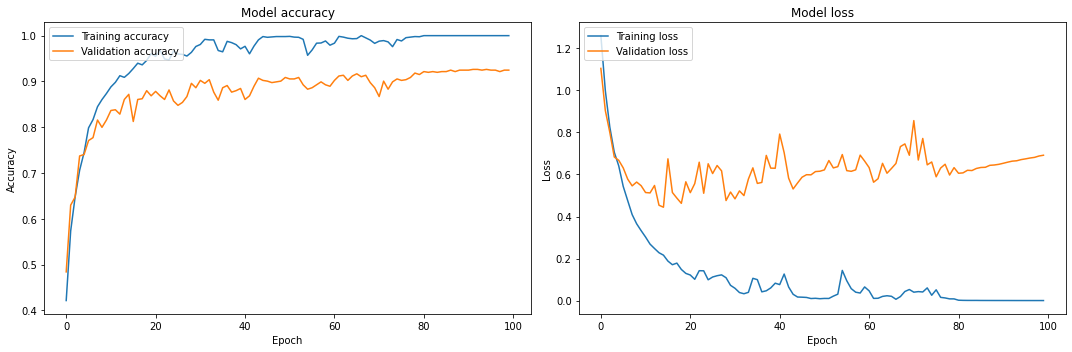

In [25]:
# Plot training & validation accuracy and loss values in the same figure (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation accuracy')
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
# Load the best model
classifier.load_weights(filepath)

## Evaluating the model

In [26]:
# Print the accuracy
score = classifier.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9262820482254028


20/20 [==============================] - 0s 1ms/step


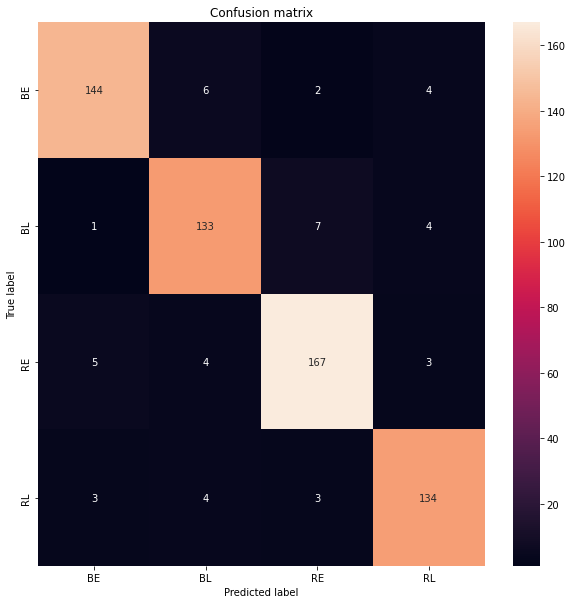

In [27]:
# Print the confusion matrix with labels names
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Interpreting the model

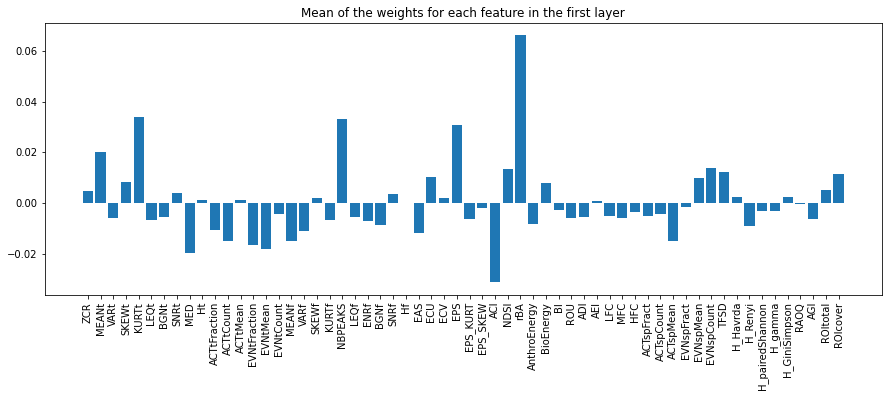

In [28]:
# Understanding the most important features for the model
from keras import backend as K
import matplotlib.pyplot as plt

# Get the weights of the first layer
weights = classifier.layers[0].get_weights()[0]

# Get the mean of the weights for each feature
mean_weights = np.mean(weights, axis=1)

# Plot very nicely the mean of the weights for each feature in a bar chart with the feature names
plt.figure(figsize=(15, 5))
plt.title('Mean of the weights for each feature in the first layer')
plt.bar(df.columns[3:-1], mean_weights)
plt.xticks(rotation=90)
plt.show()